In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl

import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS



In [2]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/8thRun/"

In [4]:
Ups4S_file = uproot.open(nfs_path + "Ups4S_NN_predicted.root:variables;1")
df_Ups4S = Ups4S_file.arrays(library="pd")

In [5]:
FSPs_file = uproot.open(nfs_path + "FSPs.root:variables;1")
df_FSPs = FSPs_file.arrays(library="pd")

In [ ]:
evt_counter_file = uproot.open(nfs_path + "evt_counter.root:variables;1")
df_evt_counter = evt_counter_file.arrays(library="pd")

In [ ]:
df_evt_counter.groupby(["__event__","__production__"]).ngroups

In [6]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(df_FSPs.shape[0])

210632
45266
853701


In [ ]:
print(df_evt_counter.shape[0])

## save df's

In [5]:
df_FSPs.to_csv(nfs_path + "FSPs_df.csv")
df_Ups4S.to_csv(nfs_path + "Ups4S_df.csv")

In [8]:
df_evt_counter.to_csv(nfs_path + "evt_counter_df.csv")

## load df's

In [6]:
df_Ups4S = pd.read_csv(nfs_path + "Ups4S_df.csv")
df_FSPs = pd.read_csv(nfs_path + "FSPs_df.csv")
#df_evt_counter = pd.read_csv(nfs_path + "evt_counter_df.csv")

# Analysis

In [7]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

45271

## check DO decays

In [8]:
df_Ups4S['Bsig_uniqParID'] = df_Ups4S.apply(whichBisSig_NAHS, axis=1)

In [9]:
df_Ups4S['D0_decay'] = df_Ups4S.apply(D0_decay_type, axis=1)

In [10]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
#BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

In [11]:
df_Ups4S['D0_decay'].value_counts()

notWanted     148133
Kpipi0         27225
Kpipipipi0     16794
Kpipipi        12641
Kpi             5839
Name: D0_decay, dtype: int64

In [12]:
df_Ups4S = df_Ups4S[df_Ups4S['D0_decay'] != "notWanted"]

In [13]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Ups4S["__event__"])]

### add and check cols

In [14]:
df_FSPs['B_ID'] = df_FSPs.apply(B_ID, axis=1)

In [15]:
df_Ups4S['Bsig_uniqParID_pdMethod'] = df_Ups4S.apply(whichBisSig, axis=1)

In [16]:
Hc_motherB_df = df_FSPs[df_FSPs["NN_prediction"].isna() == True].drop_duplicates(subset=("__event__"), keep='first')

In [17]:
Hc_motherB_df["B_tag_ID"] = Hc_motherB_df["B_ID"]

In [18]:
Hc_motherB_df[["__event__","__production__","B_ID","B_tag_ID","NN_prediction"]]

,__event__,__production__,B_ID,B_tag_ID,NN_prediction
1,2335906,16816,83886082,83886082,NaN
3,2336150,16816,83886082,83886082,NaN
32,2422,16816,83886081,83886081,NaN
38,8666,16816,83886081,83886081,NaN
58,4072101,16816,83886081,83886081,NaN
...,...,...,...,...,...
853210,32256045,16816,83886082,83886082,NaN
853466,6861604,16816,83886081,83886081,NaN
853513,477883,16816,83886081,83886081,NaN
853523,479935,16816,83886081,83886081,NaN


In [19]:
df_FSPs.shape[0]

258443

In [20]:
df_FSPs = pd.merge(df_FSPs,Hc_motherB_df[["__event__","__production__","B_tag_ID"]], on=["__event__","__production__"])

In [21]:
df_FSPs.shape[0]

257085

In [22]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        B_tagID = s['B_tag_ID']
        
        if int(s['B_ID']) == B_tagID:
            label = 1 # X
        else:
            label = 2 # Bsig
    return label
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [23]:
df_FSPs["correct_pred"] = (df_FSPs["label"] == df_FSPs["NN_prediction"]).astype(int)

In [24]:
df_FSPs["correct_pred"].describe()

count    257085.000000
mean          0.527059
std           0.499268
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [25]:
df_FSPs[["__event__","B_ID","NN_prediction","B_tag_ID","label"]][:20]

,__event__,B_ID,NN_prediction,B_tag_ID,label
0,2335906,83886082,1.0,83886082,1
1,2335906,83886082,NaN,83886082,1
2,2335906,83886081,2.0,83886082,2
3,2335906,83886082,NaN,83886082,1
4,2335906,0,0.0,83886082,0
5,2335906,83886082,NaN,83886082,1
6,2335906,83886082,0.0,83886082,1
7,2335906,83886081,0.0,83886082,2
8,2335906,83886082,1.0,83886082,1
9,2335906,83886082,1.0,83886082,1


## see correct prediction rate of NN

In [26]:
df_FSPs["correct_pred"].describe()

count    257085.000000
mean          0.527059
std           0.499268
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [27]:
df_FSPs["NN_prediction"].describe()

count    211421.000000
mean          1.172244
std           0.760427
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: NN_prediction, dtype: float64

In [28]:
df_FSPs[df_FSPs["NN_prediction"].notna() == True].shape[0]/df_FSPs.shape[0]

0.8223778127856546

In [29]:
nonHc_FSPs = df_FSPs[df_FSPs["NN_prediction"].notna() == True]

In [30]:
nonHc_FSPs[nonHc_FSPs["NN_prediction"].notna() == True].shape[0]/nonHc_FSPs.shape[0]

1.0

In [31]:
nonHc_FSPs["correct_pred"].describe()

count    211421.000000
mean          0.640897
std           0.479739
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [32]:
nonHc_FSPs.shape[0]

211421

## lepton based truth matching

In [33]:
df_Ups4S["lep_motherPDG"].value_counts()

-511.0      23136
 511.0      22028
 223.0       2178
 22.0        1637
 113.0       1594
            ...  
 20443.0        2
 4112.0         2
-3112.0         2
-2214.0         2
-2114.0         2
Name: lep_motherPDG, Length: 72, dtype: int64

In [34]:
df_Ups4S["lep_PDG"].value_counts()

 13.0    17266
-13.0    15992
-11.0    14628
 11.0    14613
Name: lep_PDG, dtype: int64

In [35]:
df_Ups4S["lep_mcPDG"].value_counts()

 11.0      12644
-11.0      12312
 13.0      11817
-13.0      11542
-211.0      6629
 211.0      6101
-321.0       391
 321.0       341
-2212.0       36
 2212.0       22
Name: lep_mcPDG, dtype: int64

In [36]:
def lep_typeMC(s):
    label = "none"
    if np.isnan(s["lep_mcPDG"]) == True:
        return label
    
    abs_lep_mcPDG = int(abs(s["lep_mcPDG"]))
    if abs_lep_mcPDG == 13:
        label = "mu"
    elif abs_lep_mcPDG == 11:
        label = "e" 
    return label

df_Ups4S['lep_typeMC'] = df_Ups4S.apply(lep_typeMC, axis=1)

def lep_type(s):
    label = "none"
    if np.isnan(s["lep_PDG"]) == True:
        return label
    
    abs_lep_PDG = int(abs(s["lep_PDG"]))
    if abs_lep_PDG == 13:
        label = "mu"
    elif abs_lep_PDG == 11:
        label = "e" 
    return label
df_Ups4S['lep_type'] = df_Ups4S.apply(lep_type, axis=1)

In [37]:
df_Ups4S['lep_typeMC'].value_counts()

e       24956
mu      23359
none    14184
Name: lep_typeMC, dtype: int64

In [38]:
groups_lep = pd.DataFrame({'count' : df_Ups4S.groupby( ["lep_typeMC","lep_type"] ).size()}).reset_index()
groups_lep

,lep_typeMC,lep_type,count
0,e,e,24374
1,e,mu,582
2,mu,e,550
3,mu,mu,22809
4,none,e,4317
5,none,mu,9867


In [39]:
def lep_MC_truth(s):
    label = 0
    if np.isnan(s["lep_motherPDG"]) == True:
        return label
    if s["lep_typeMC"] == "none":
        return label
    
    abs_lep_motherPDG = int(abs(s["lep_motherPDG"]))
    if abs_lep_motherPDG == 511:
        label = 1
   
    return label

df_Ups4S['lep_MC_truth'] = df_Ups4S.apply(lep_MC_truth, axis=1)

In [40]:
df_Ups4S['lep_MC_truth']
df_Ups4S["lep_MC_truth"]
df_Ups4S

,__experiment__,__run__,__event__,__production__,__candidate__,__ncandidates__,__weight__,m2RecoilSignalSide,foxWolframR2_maskedNaN,foxWolframR2,...,Dst_DeltaM,Dst_isSignal,roeE_ofUps4S,E_predicted_bg_gammas,D0_decay,abs_m2RecoilSignalSide,Bsig_uniqParID_pdMethod,lep_typeMC,lep_type,lep_MC_truth
0,1003,0,2335906,16816,0,6,1.0,10.427878,0.160597,0.160597,...,0.185958,0.0,2.087690,0.323788,Kpipipipi0,10.427878,83886081.0,none,mu,0
1,1003,0,2335906,16816,1,6,1.0,10.427879,0.160597,0.160597,...,0.411289,0.0,2.087690,0.323788,Kpipipipi0,10.427879,83886081.0,none,mu,0
2,1003,0,2335906,16816,2,6,1.0,8.013919,0.160597,0.160597,...,0.185958,0.0,1.728469,0.323788,Kpipipipi0,8.013919,83886081.0,mu,mu,1
3,1003,0,2335906,16816,3,6,1.0,8.013919,0.160597,0.160597,...,0.411289,0.0,1.728469,0.323788,Kpipipipi0,8.013919,83886081.0,mu,mu,1
4,1003,0,2335906,16816,4,6,1.0,14.010217,0.160597,0.160597,...,0.185958,0.0,2.391627,0.323788,Kpipipipi0,14.010217,83886081.0,none,mu,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210601,1003,0,7940578,16816,4,9,1.0,3.623107,0.175366,0.175366,...,0.535316,0.0,1.464669,0.333493,Kpipi0,3.623107,83886081.0,e,e,1
210602,1003,0,7940578,16816,5,9,1.0,2.149394,0.175366,0.175366,...,0.468363,0.0,0.935988,0.333493,Kpipi0,2.149394,83886081.0,e,e,1
210603,1003,0,7940578,16816,6,9,1.0,4.169189,0.175366,0.175366,...,0.515481,0.0,1.610965,0.333493,Kpipi0,4.169189,83886081.0,e,e,1
210604,1003,0,7940578,16816,7,9,1.0,3.623108,0.175366,0.175366,...,0.472800,0.0,1.464669,0.333493,Kpipi0,3.623108,83886081.0,e,e,1


In [41]:
df_Ups4S['lep_MC_truth'].describe()

count    62499.000000
mean         0.691387
std          0.461925
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: lep_MC_truth, dtype: float64

## save dfs now with all labels added

In [42]:
nonHc_FSPs.to_csv(nfs_path + "nonHc_FSPs_df.csv")
df_Ups4S.to_csv(nfs_path + "Ups4S_df.csv")

## load dfs with labels

In [3]:
df_Ups4S = pd.read_csv(nfs_path + "Ups4S_df.csv")
nonHc_FSPs = pd.read_csv(nfs_path + "nonHc_FSPs_df.csv")

## more analysis

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


<AxesSubplot:>

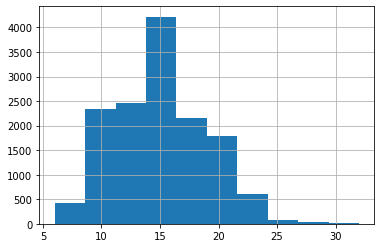

In [5]:
numFSPs_all = pd.DataFrame({'count' : nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()
numFSPs_all["count"].hist()

In [6]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","__production__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()

<AxesSubplot:>

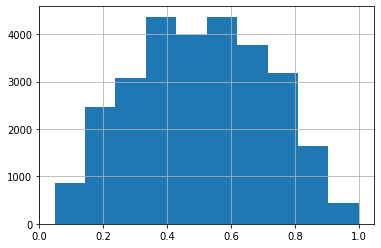

In [7]:
percCorrect_df['frac. correct FSPs'].hist()

## BCS

In [8]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(nonHc_FSPs.shape[0])

62499
14201
211421


In [9]:
nonHc_FSPs.keys()

Index(['Unnamed: 0', '__experiment__', '__run__', '__event__',
       '__production__', '__candidate__', '__ncandidates__', '__weight__',
       'genMothPDG_0', 'genMothPDG_1', 'genMothPDG_2', 'genMothPDG_3',
       'genMothPDG_4', 'genMothPDG_5', 'genMothPDG_6', 'genMothPDG_7',
       'genMothPDG_8', 'genMothPDG_9', 'genMotherID_0', 'genMotherID_1',
       'genMotherID_2', 'genMotherID_3', 'genMotherID_4', 'genMotherID_5',
       'genMotherID_6', 'genMotherID_7', 'genMotherID_8', 'genMotherID_9',
       'mcMother0_uniqParID', 'mcMother1_uniqParID', 'mcMother2_uniqParID',
       'mcMother3_uniqParID', 'mcMother4_uniqParID', 'mcMother5_uniqParID',
       'mcMother6_uniqParID', 'mcMother7_uniqParID', 'mcMother8_uniqParID',
       'mcMother9_uniqParID', 'cmpx', 'cmpy', 'cmpz', 'cmE', 'isSignal',
       'uniqueParticleIdentifier', 'mcErrors', 'mcPDG', 'genMotherID',
       'genMotherP', 'genMotherPDG', 'charge', 'dr', 'dz', 'clusterReg',
       'clusterE9E21', 'M', 'PDG', 'genParticleID', 

In [10]:
for key in df_Ups4S.keys():
    print(key)

Unnamed: 0
__experiment__
__run__
__event__
__production__
__candidate__
__ncandidates__
__weight__
m2RecoilSignalSide
foxWolframR2_maskedNaN
foxWolframR2
extraInfo__boFEIProbabilityRank__bc
nTracks
dau1_sigProb
Up4S_isSig
BeamE
BeamPx
BeamPy
BeamPz
BeamcmsE
BeamcmsPx
BeamcmsPy
BeamcmsPz
genUp4S_uniqParID_0
genUp4S_PDG_0_0
abs_genUp4S_PDG_0_0
genUp4S_uniqParID_0_0
genUp4S_PDG_0_0_0
genUp4S_uniqParID_0_0_0
genUp4S_PDG_0_0_0_0
genUp4S_uniqParID_0_0_0_0
genUp4S_PDG_0_0_0_0_0
genUp4S_uniqParID_0_0_0_0_0
genUp4S_PDG_0_0_0_0_1
genUp4S_uniqParID_0_0_0_0_1
genUp4S_PDG_0_0_0_0_2
genUp4S_uniqParID_0_0_0_0_2
genUp4S_PDG_0_0_0_0_3
genUp4S_uniqParID_0_0_0_0_3
genUp4S_PDG_0_0_0_0_4
genUp4S_uniqParID_0_0_0_0_4
genUp4S_PDG_0_0_0_0_5
genUp4S_uniqParID_0_0_0_0_5
genUp4S_PDG_0_0_0_1
genUp4S_uniqParID_0_0_0_1
genUp4S_PDG_0_0_0_1_0
genUp4S_uniqParID_0_0_0_1_0
genUp4S_PDG_0_0_0_1_1
genUp4S_uniqParID_0_0_0_1_1
genUp4S_PDG_0_0_0_1_2
genUp4S_uniqParID_0_0_0_1_2
genUp4S_PDG_0_0_0_1_3
genUp4S_uniqParID_0_0_0_1_3

In [11]:
df_Ups4S.shape[0]

62499

In [12]:
df_Ups4S[["__event__"]].nunique()

__event__    14201
dtype: int64

In [13]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

14201

In [14]:
variables=["Up4S_isSig","Dst_isSignal","D_isSignal","dau0_dau0_isSignal","Hc_isSignalAcceptMissingGamma","dau0_isSignal","dau1_isSignal"]
for var in variables:
    print('\n',var)
    print(df_Ups4S[var].describe())
    


 Up4S_isSig
count    32372.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Up4S_isSig, dtype: float64

 Dst_isSignal
count    55744.000000
mean         0.002834
std          0.053164
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Dst_isSignal, dtype: float64

 D_isSignal
count    56288.000000
mean         0.008154
std          0.089934
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: D_isSignal, dtype: float64

 dau0_dau0_isSignal
count    62499.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: dau0_dau0_isSignal, dtype: float64

 Hc_isSignalAcceptMissingGamma
count    62499.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name

<AxesSubplot:>

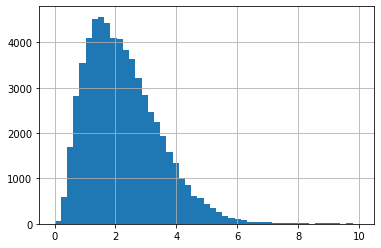

In [15]:
bins = np.linspace(0, 10, 50)
df_Ups4S["roeE_ofUps4S"].hist(bins=bins)

<AxesSubplot:>

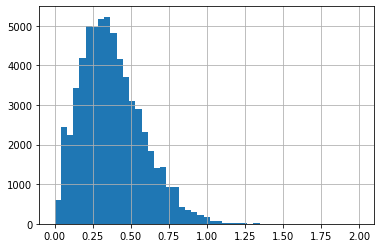

In [16]:
bins = np.linspace(0, 2, 50)
df_Ups4S["E_predicted_bg_gammas"].hist(bins=bins)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

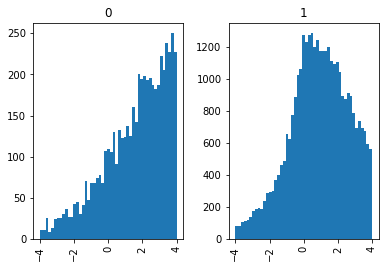

In [17]:
bins = np.linspace(-4, 4, 50)
df_Ups4S.hist("m2RecoilSignalSide", bins=bins, by='lep_MC_truth')

In [18]:
df_Ups4S["lep_MC_truth"].describe()

count    62499.000000
mean         0.691387
std          0.461925
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: lep_MC_truth, dtype: float64

In [19]:
df_Ups4S["Up4S_isSig"].describe()

count    32372.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Up4S_isSig, dtype: float64

14201
14201
14201
14201
14201
14201


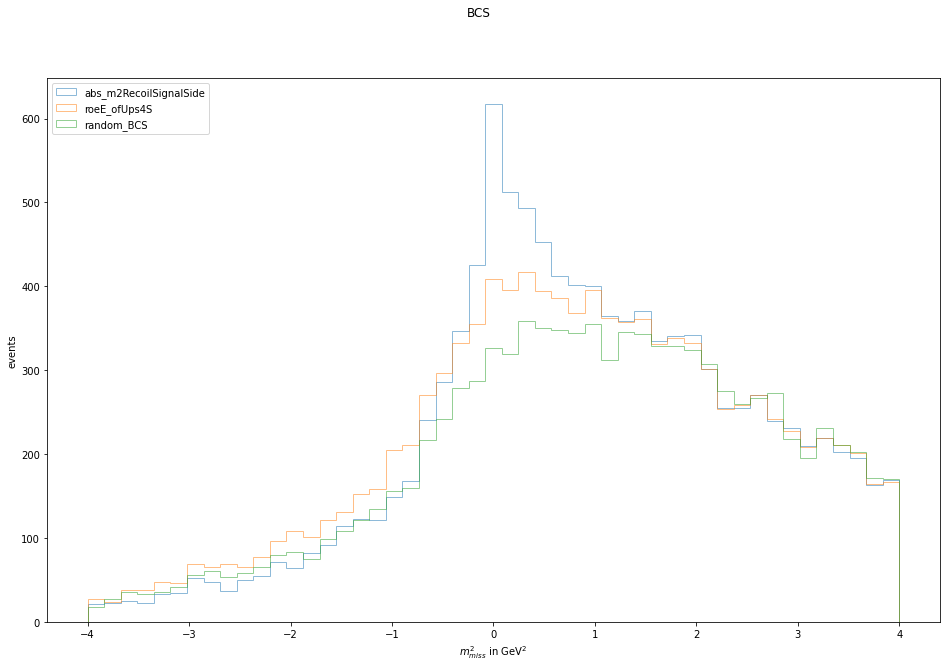

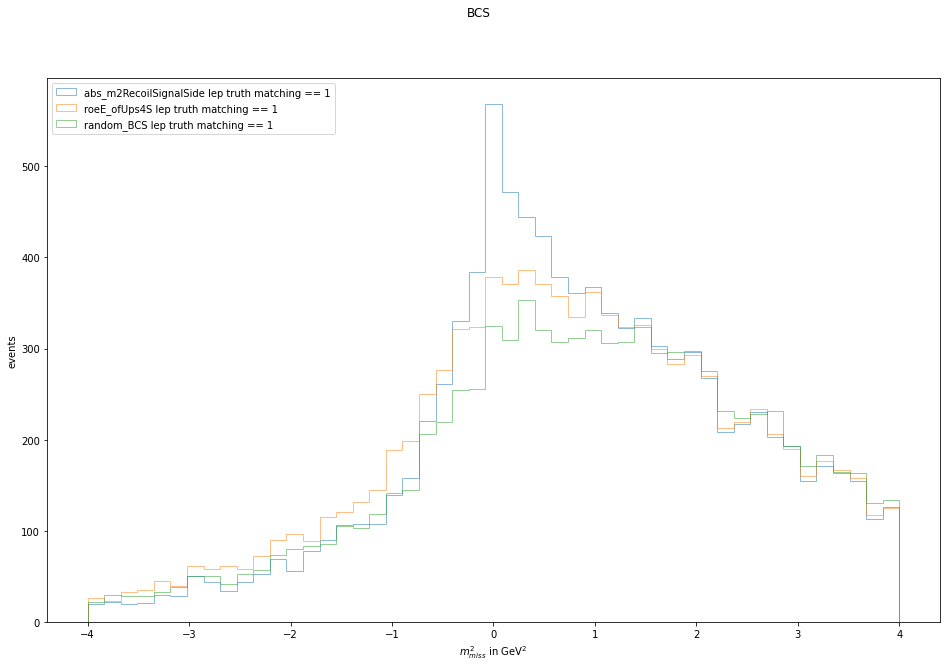

In [20]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 

for lep_truth in ["off","on"]:
    fig, ax = plt.subplots()
    fig.suptitle('BCS')

    for var in ["abs_m2RecoilSignalSide","roeE_ofUps4S","random_BCS"]:

        if var == "random_BCS":
            # this takes a sample of all events which results in shuffling the evts
            tmp = df_Ups4S.sample(frac=1)
            # now keeping the first results in random BCS
            tmp = tmp.drop_duplicates(subset=("__event__"), keep='first')
        else:
            tmp = df_Ups4S.sort_values(var,ascending=True).drop_duplicates(subset=("__event__"), keep='first')



        print(tmp.shape[0])
        bins = np.linspace(-4, 4, 50)

        fig.set_size_inches(16, 10)

        ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
        ax.set_ylabel("events")
        
        if lep_truth == "off":
            ax.hist(tmp.m2RecoilSignalSide, bins, alpha=0.5, label=var ,histtype='step')
        elif lep_truth == "on":    
            ax.hist(tmp[tmp["lep_MC_truth"] == 1].m2RecoilSignalSide, bins, alpha=0.5, label=var + " lep truth matching == 1" ,histtype='step')

        ax.legend(loc='upper left')



    plt.savefig(f'plots/onlineNN_m2Recoil_BCS_lepTruthCut_{lep_truth}.pdf')

14201


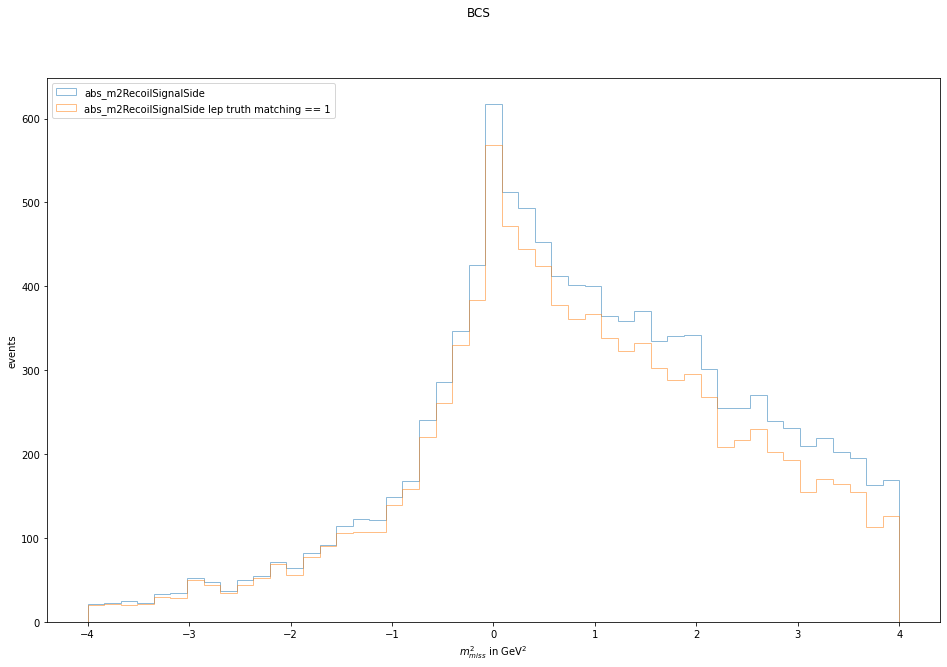

In [21]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 


fig, ax = plt.subplots()
fig.suptitle('BCS')

for var in ["abs_m2RecoilSignalSide"]:

    tmp = df_Ups4S.sort_values(var,ascending=True).drop_duplicates(subset=("__event__"), keep='first')



    print(tmp.shape[0])
    bins = np.linspace(-4, 4, 50)

    fig.set_size_inches(16, 10)

    ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
    ax.set_ylabel("events")

    ax.hist(tmp.m2RecoilSignalSide, bins, alpha=0.5, label=var ,histtype='step')
    ax.hist(tmp[tmp["lep_MC_truth"] == 1].m2RecoilSignalSide, bins, alpha=0.5, label=var + " lep truth matching == 1" ,histtype='step')

    ax.legend(loc='upper left')



    plt.savefig(f'plots/onlineNN_m2Recoil_BCS_lepTruthCut_ONLY_abs_m2RecoilSignalSide.pdf')

In [22]:
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

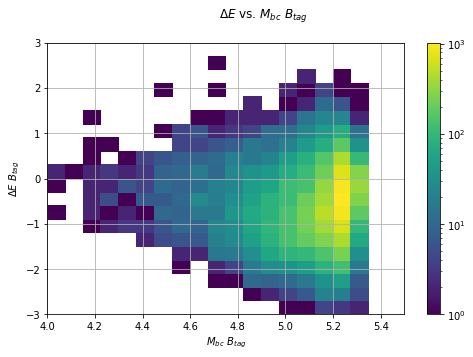

In [23]:
fig, ax = plt.subplots()
fig.suptitle(r'$\Delta E$ vs. $M_{bc}$ $B_{tag}$')

bins = np.linspace(-4, 4, 50)

fig.set_size_inches(8, 5)

ax.set_xlabel(r'$M_{bc}$ $B_{tag}$')
ax.set_ylabel(r'$\Delta E$ $B_{tag}$')


#ax.legend(loc='upper left')
h = ax.hist2d(BCS_df.dau0_Mbc,BCS_df.dau0_deltaE, range=[[4, 5.5], [-3, 3]], bins=20,
          norm=mpl.colors.LogNorm())

plt.grid()
fig.colorbar(h[3], ax=ax)


plt.savefig('plots/onlineNN_2D_deltaE_Mbc.pdf')

<AxesSubplot:>

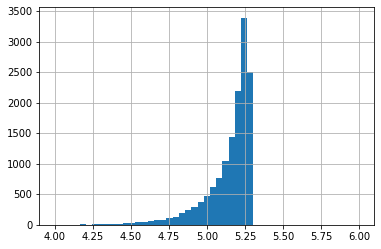

In [24]:
bins = np.linspace(4, 6, 50)
BCS_df["dau0_Mbc"].hist(bins=bins)

<AxesSubplot:>

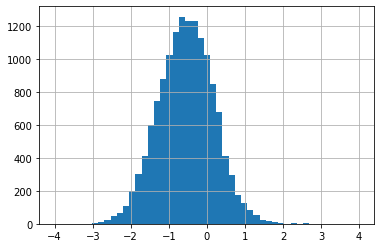

In [25]:
bins = np.linspace(-4, 4, 50)
BCS_df["dau0_deltaE"].hist(bins=bins)

<AxesSubplot:>

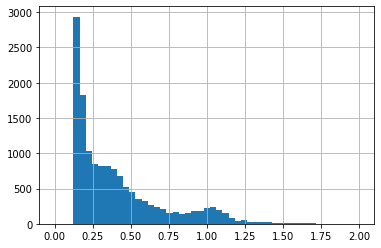

In [26]:
bins = np.linspace(0, 2, 50)
BCS_df["Dst_DeltaM"].hist(bins=bins)

<AxesSubplot:>

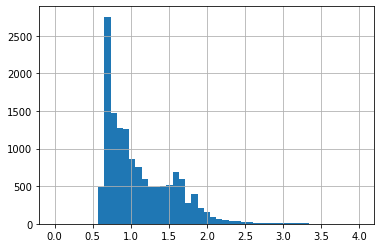

In [27]:
bins = np.linspace(0, 4, 50)
BCS_df["D_M"].hist(bins=bins)

<AxesSubplot:>

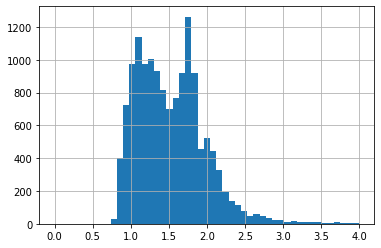

In [28]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_M"].hist(bins=bins)

<AxesSubplot:>

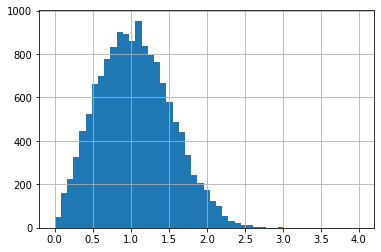

In [29]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_pt"].hist(bins=bins)

<AxesSubplot:>

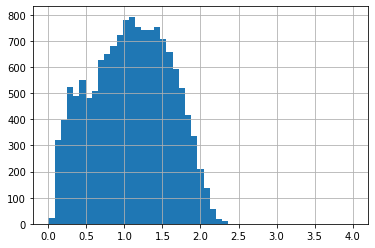

In [30]:
bins = np.linspace(0, 4, 50)
BCS_df["lep_pt"].hist(bins=bins)

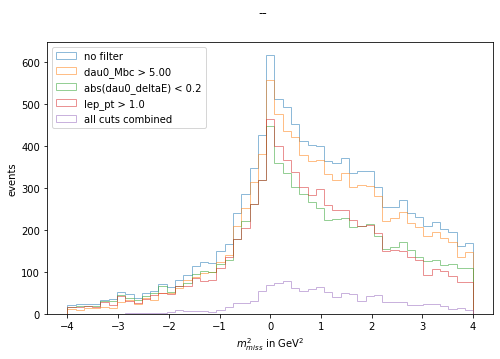

In [31]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
ax.hist(BCS_df[(BCS_df.dau0_deltaE > -.2) & BCS_df.dau0_deltaE < .2].m2RecoilSignalSide, bins, alpha=0.5, label="abs(dau0_deltaE) < 0.2" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)].m2RecoilSignalSide, bins, alpha=0.5, label="all cuts combined" ,histtype='step')

#tmp2 = BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)]
#ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="plus D M cut" ,histtype='step')

ax.legend(loc='upper left')


plt.savefig('plots/onlineNN_m2RecoilFilters.pdf')

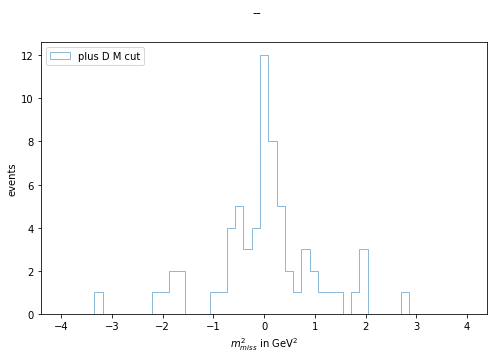

In [32]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

#ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
#ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.dau0_deltaE > -.2) & BCS_df.dau0_deltaE < .2].m2RecoilSignalSide, bins, alpha=0.5, label="abs(dau0_deltaE) < 0.2" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt,dau0_deltaE,dau0_Mbc" ,histtype='step')

tmp2 = BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)]
ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="plus D M cut" ,histtype='step')

ax.legend(loc='upper left')

## analyse how many errors per evt etc

In [33]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__"] ).size(),
                              'num corr preds' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()}).reset_index()
percCorrect_df = percCorrect_df[percCorrect_df["correct_pred"] == 1]
numFSPs = pd.DataFrame({'numFSPs' : nonHc_FSPs.groupby( ["__event__"] ).size()}).reset_index()

online_NN_results = pd.merge(percCorrect_df[["__event__","frac. correct FSPs","num corr preds"]],
                             numFSPs[["__event__","numFSPs"]],on=["__event__"],how='outer')
online_NN_results

,__event__,frac. correct FSPs,num corr preds,numFSPs
0,2422,0.750000,12,16
1,2515,0.461538,6,13
2,3765,0.750000,12,16
3,5639,0.611111,11,18
4,8666,0.666667,8,12
...,...,...,...,...
14117,50981800,0.642857,9,14
14118,50982065,0.695652,16,23
14119,50991574,0.937500,15,16
14120,50998758,0.583333,7,12


In [34]:
online_NN_results['frac. correct FSPs'] = online_NN_results['frac. correct FSPs'].fillna(0)
online_NN_results['num corr preds'] = online_NN_results['num corr preds'].fillna(0)

In [35]:
online_NN_results["num errors"] = online_NN_results["numFSPs"] - online_NN_results["num corr preds"]

## make comparison plots between online/offline application of NN

In [36]:
path_df = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/MM2plotFromPreds/"
offline_NN_results = pd.read_csv(path_df + "offline_NN_results.csv")

In [37]:
offline_NN_results.keys()

Index(['Unnamed: 0', 'event', 'frac. correct FSPs', 'num corr preds',
       'numFSPs', 'px_summed_bg', 'py_summed_bg', 'pz_summed_bg',
       'E_summed_bg', 'CMSpx_summed_bg', 'CMSpy_summed_bg', 'CMSpz_summed_bg',
       'CMSE_summed_bg', 'px_summed_X', 'py_summed_X', 'pz_summed_X',
       'E_summed_X', 'CMSpx_summed_X', 'CMSpy_summed_X', 'CMSpz_summed_X',
       'CMSE_summed_X', 'px_summed_Bs', 'py_summed_Bs', 'pz_summed_Bs',
       'E_summed_Bs', 'CMSpx_summed_Bs', 'CMSpy_summed_Bs', 'CMSpz_summed_Bs',
       'CMSE_summed_Bs', 'Hc_px', 'Hc_py', 'Hc_pz', 'Hc_E', 'Hc_cmpx',
       'Hc_cmpy', 'Hc_cmpz', 'Hc_cmE', 'Hc_cmPx', 'Hc_cmPy', 'Hc_cmPz',
       'num errors', 'Mbc_Btag', 'MM2recoilSignalSide', 'deltaE',
       'summed_wrongPred_p'],
      dtype='object')

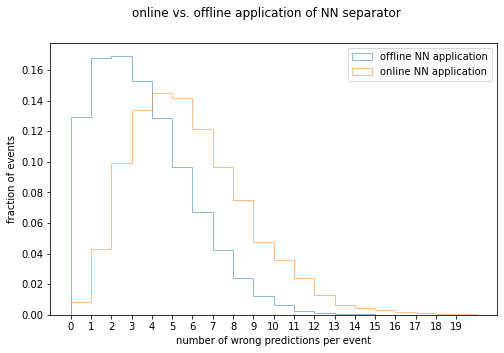

In [38]:
fig, ax = plt.subplots()
num_steps=20
bins = np.linspace(0, num_steps, 21)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of wrong predictions per event')
ax.set_ylabel("fraction of events")

plt.xticks(np.arange(0, num_steps, step=1))

ax.hist(offline_NN_results["num errors"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["num errors"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper right')

#plt.grid()

plt.savefig('plots/onlineVSofflineNN_numErrorsPerEvent.pdf')

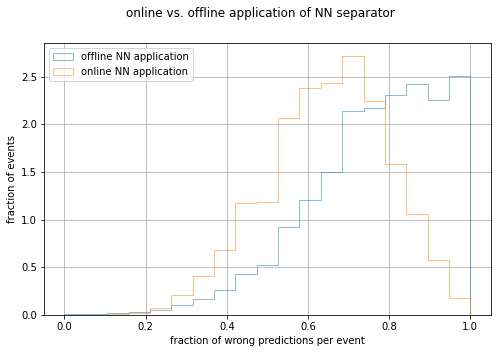

In [39]:
fig, ax = plt.subplots()

bins = np.linspace(0, 1, 20)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'fraction of wrong predictions per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/onlineVSofflineNN_fracErrorsPerEvent.pdf')

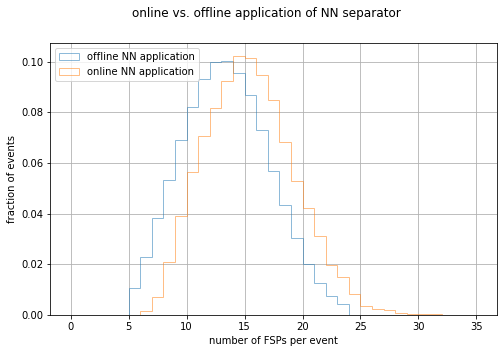

In [40]:
fig, ax = plt.subplots()

bins = np.linspace(0, 35, 36)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of FSPs per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/onlineVSofflineNN_numFSPs.pdf')